# <span style="color:black; font-weight:bold;">Simulated data Tutorial</span>
#### • <span style="color:black; font-weight:bold;">Creator</span>: Bingjie Dai (17516970902@163.com)
#### • <span style="color:black; font-weight:bold;">Date of Creation</span>: 10.10.2025
#### • <span style="color:black; font-weight:bold;">Date of Last Modification</span>: 10.10.2025
#### • <span style="color:black; font-weight:bold;">Download</span>: Simulated data used in the tutorial is available at [simulatedata.h5ad](https://drive.google.com/open?id=1DnPjxTxS6fLjWtfio__s_yMvgp0zqqhS&usp=drive_fs)
In this tutorial we apply SpaLP to Simulated data from [Gong, Y.Unveiling fine-scale spatial structures and amplifying gene expression signals in ultra-large ST slices with HERGAST. Nat Commun 16, 3977 (2025).](https://doi.org/10.1038/s41467-025-59139-w)

<span style="color:black; font-weight:bold;">The dataset have:</span>   
• <span style="color:black; font-weight:bold;">Simulated data</span>: 640,000 cells and 31,493 genes 

## <span style="color:black; font-weight:bold;">Loading package</span>

In [1]:
from SpaLP.utils import prepare_inputs, set_seed,create_new_color_dict,Graph
from SpaLP.RandLA import SpatialAutoencoder
import torch
import torch.nn as nn
import torch.optim as optim
import warnings
import scanpy as sc
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import anndata as ad
from tqdm import tqdm
import time

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
set_seed(7)

## <span style="color:black; font-weight:bold;">Loading simulated data</span>
The simulation data contains 640,000 cells and 31,493 genes.

In [4]:
adata=sc.read_h5ad('/home/dbj/HERGAST/simulatedata.h5ad')
adata.var_names_make_unique()
adata

AnnData object with n_obs × n_vars = 640000 × 31493
    obs: 'ann_level_3'
    var: 'feature_is_filtered', 'original_gene_symbols', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'feature_type', 'n_cells'
    uns: 'batch_condition', 'citation', 'default_embedding', 'schema_reference', 'schema_version', 'title'
    obsm: 'X_scanvi_emb', 'X_umap', 'spatial'
    layers: 'soupX'
    obsp: 'connectivities', 'distances'

## <span style="color:black; font-weight:bold;">Data preprocessing</span>
We use [scanpy](https://scanpy.readthedocs.io/en/stable/installation.html) package to select top2000 HVGs and perform standard data processing.  
The standard processed expression matrix was saved in adata.obsm[<span style="color:red;">'feat'</span>] and used as input to the model.

In [5]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000, flavor='seurat_v3')
adata = adata[:,adata.var.highly_variable]
adata.raw=adata
sc.pp.normalize_total(adata, target_sum=1e4,inplace=True)
sc.pp.log1p(adata)
sc.pp.scale(adata)
adata.obsm['feat'] = adata.X

## <span style="color:black; font-weight:bold;">Compute Spatial Neighbor Graph and build the neighbor index matrix</span>
We compute the spatial Graph using 5 neighbors in simulated data. k=5

In [6]:
k=5
graph = prepare_inputs(adata, k, device)

## <span style="color:black; font-weight:bold;">Define Parameters</span>
The hidden layer dimension is 64, the Adam optimizer is used to optimize the model, the learning rate lr is 0.001, and the model is trained for 200 epochs.

In [7]:
in_channels = graph.features.shape[1]
model = SpatialAutoencoder(in_channels, out_channels=64).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [8]:
set_seed(7)
epochs = 200
pbar = tqdm(range(epochs), desc="Training",ncols=200)
for epoch in pbar:
    start_time = time.time()
    model.train()
    optimizer.zero_grad()
    reconstructed,embedding = model(graph.features, graph.neighbor_idx)
    loss = criterion(reconstructed, graph.features)
    loss.backward()
    optimizer.step()
    elapsed = time.time() - start_time
    pbar.set_postfix({"Epoch": epoch,"Loss": f"{loss.item():.4f}"})

Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:52<00:00,  3.84it/s, Epoch=199, Loss=0.9247]


## <span style="color:black; font-weight:bold;">Generate cell embedding and reconstructed gene expression</span>
Cell embedding was saved in adata.obsm[<span style="color:red;">'SpaLP'</span>]. Reconstructed gene expression is constructed as adata2

In [9]:
model.eval()
with torch.no_grad():
    reconstructed,embedding = model(graph.features, graph.neighbor_idx)
    reconstructed = reconstructed.cpu().numpy()
    embedding=embedding.cpu().numpy()

### Cell embedding

In [10]:
adata.obsm['SpaLP']=embedding

### Reconstructed gene expression

In [11]:
adata2=sc.AnnData(reconstructed)
adata2.obs=adata.obs
adata2.var=adata.var
adata2.uns=adata.uns
adata2.obsm=adata.obsm

## <span style="color:black; font-weight:bold;">Identify Niches</span>
We compute Leiden clustering based on the SpaLP embeddings to identify spatial niches.

In [16]:
sc.pp.neighbors(adata, use_rep='SpaLP')
sc.tl.leiden(adata, random_state=2024, resolution=0.013,key_added='SpaLP')

## <span style="color:black; font-weight:bold;">The ground truth of simulated data</span>

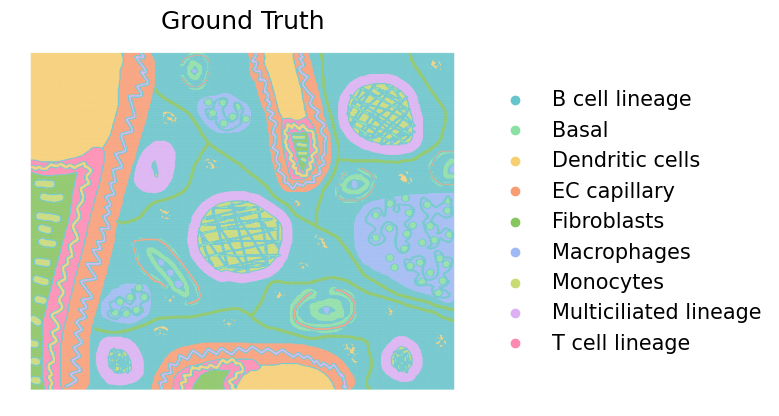

In [22]:
import matplotlib.pyplot as plt
import copy
plt.rcParams['figure.figsize'] = (6,4.8)
plt.rcParams['font.size'] = 15
latent_cluster_colors = create_new_color_dict(adata=adata,cat_key='ann_level_3')
sc.pl.embedding(adata,color='ann_level_3',basis='spatial',s=1,title='Ground Truth',frameon=False, palette=latent_cluster_colors)

## <span style="color:black; font-weight:bold;">Niche identified by SpaLP</span>

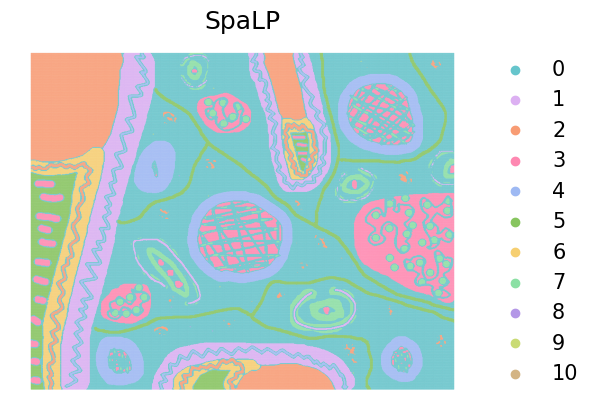

In [23]:
import matplotlib.pyplot as plt
import copy
plt.rcParams['figure.figsize'] = (6,4.8)
plt.rcParams['font.size'] = 15
latent_cluster_colors = create_new_color_dict(adata=adata,cat_key='SpaLP')
sc.pl.embedding(adata,color='SpaLP',basis='spatial',s=1,title='SpaLP',frameon=False, palette=latent_cluster_colors)

## <span style="color:black; font-weight:bold;">Calculate supervision metrics</span>
We use six supervised metrics from the [sklearn.metrics](https://scikit-learn.org/stable/api/sklearn.metrics.html#module-sklearn.metrics) to evaluate the performance of SpaLP, namely ARI NMI AMI FMI V-Measure Homogeneity

In [21]:
import numpy as np
from sklearn.metrics import (homogeneity_score,v_measure_score,adjusted_mutual_info_score,normalized_mutual_info_score,adjusted_rand_score,fowlkes_mallows_score)

true_labels = np.array(adata.obs['ann_level_3'])
cluster_labels = np.array(adata.obs['SpaLP'])

FMI = fowlkes_mallows_score(true_labels, cluster_labels)
homogeneity = homogeneity_score(true_labels, cluster_labels)
v_measure = v_measure_score(true_labels, cluster_labels)
ami = adjusted_mutual_info_score(true_labels, cluster_labels)
nmi = normalized_mutual_info_score(true_labels, cluster_labels)
ari = adjusted_rand_score(true_labels, cluster_labels)

print("Homogeneity:", homogeneity)
print("ARI:", ari)
print("NMI:", nmi)
print("AMI:", ami)
print("FMI:", FMI)
print("V-Measure:", v_measure)

Homogeneity: 0.8780196203054496
ARI: 0.899744008804288
NMI: 0.8768092938043112
AMI: 0.8768042502418241
FMI: 0.9321627759919207
V-Measure: 0.876809293804311


## <span style="color:black; font-weight:bold;">Original gene expression spatial map</span>

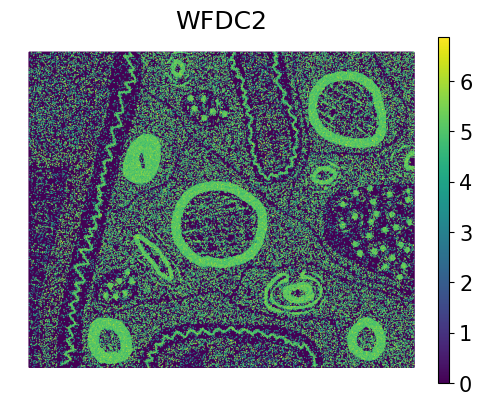

In [28]:
import matplotlib.pyplot as plt
import copy
plt.rcParams['figure.figsize'] = (6,4.5)
plt.rcParams['font.size'] = 15
sc.pl.embedding(adata,color='WFDC2',basis='spatial',s=3,frameon=False)

## <span style="color:black; font-weight:bold;">Reconstructed gene expression spatial map</span>

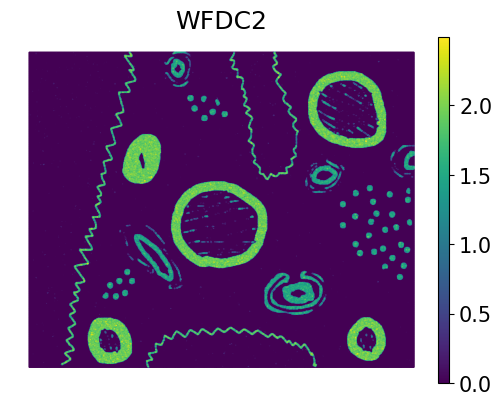

In [12]:
import matplotlib.pyplot as plt
import copy
plt.rcParams['figure.figsize'] = (6,4.5)
plt.rcParams['font.size'] = 15
sc.pl.embedding(adata2,color='WFDC2',basis='spatial',s=3,frameon=False)

## <span style="color:black; font-weight:bold;">Original marker gene expression heatmap</span>

In [13]:
adata.obs['cell_type']=adata.obs['ann_level_3']
sc.tl.rank_genes_groups(adata, groupby="cell_type", method="wilcoxon")
adata.uns["rank_features_groups"]=adata.uns["rank_genes_groups"]

Index(['B cell lineage', 'Dendritic cells', 'EC capillary',
       'Multiciliated lineage', 'Fibroblasts', 'Macrophages', 'T cell lineage',
       'Monocytes', 'Basal'],
      dtype='object')


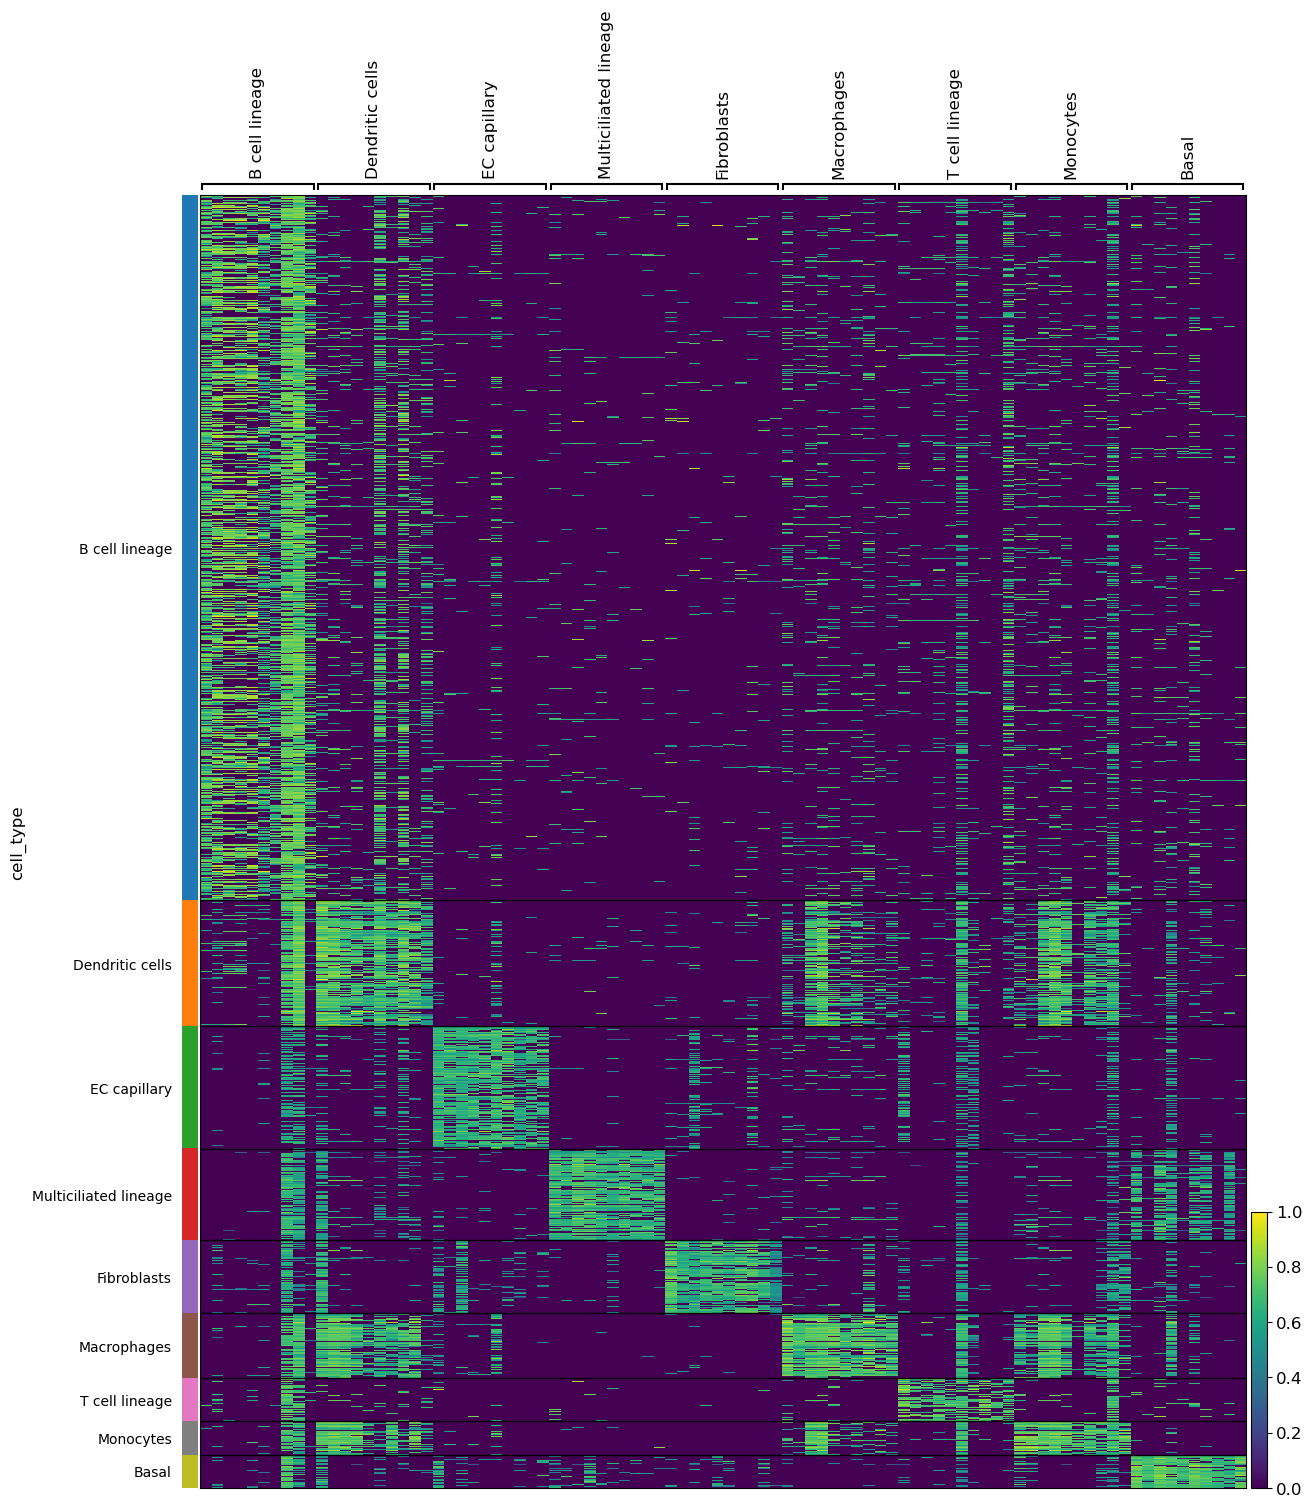

In [14]:
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 12
new_order = (adata.obs['cell_type'].value_counts().index.tolist())
adata.obs['cell_type'] = pd.Categorical(adata.obs['cell_type'], categories=new_order, ordered=True)
print(adata.obs['cell_type'].cat.categories)
cell_types = new_order

result = adata.uns['rank_features_groups']
names_array = result['names']
scores_array = result['scores']
pvals_array = result['pvals']
pvals_adj_array = result['pvals_adj']
logfoldchanges_array = result['logfoldchanges']

# Reorder each array
def reorder_recarray(recarray, new_order):  
    new_dtype = [(name, recarray.dtype[name]) for name in new_order]
    new_recarray = np.empty(recarray.shape, dtype=new_dtype)
    for name in new_order:
        new_recarray[name] = recarray[name]
    return new_recarray

result['names'] = reorder_recarray(names_array, new_order)
result['scores'] = reorder_recarray(scores_array, new_order)
result['pvals'] = reorder_recarray(pvals_array, new_order)
result['pvals_adj'] = reorder_recarray(pvals_adj_array, new_order)
result['logfoldchanges'] = reorder_recarray(logfoldchanges_array, new_order)
adata.uns['rank_features_groups']=result
groups =cell_types
markers = pd.DataFrame(
    {group +  key[:1]: result[key][group]
    for group in groups for key in ['names']}).head(10).T
markers = np.array(markers.values).reshape(1,-1)[0]
sc.pl.heatmap(adata, markers, groupby='cell_type',var_group_positions = [(0,9),(10,19),(20,29),(30,39),(40,49),(50,59),(60,69),(70,79),(80,89),(90,99),(100,109),(110,119),(120,129),(130,139),(140,149),(150,159),(160,169),(170,179),(180,189),(190,199)],
              var_group_labels = cell_types,standard_scale="var",figsize=(14, 17),show = True)

## <span style="color:black; font-weight:bold;">Reconstructed marker gene expression heatmap</span>

In [15]:
adata2.obs['cell_type']=adata.obs['cell_type']
sc.tl.rank_genes_groups(adata2, groupby="cell_type", method="wilcoxon")
adata2.uns["rank_features_groups"]=adata2.uns["rank_genes_groups"]

Index(['B cell lineage', 'Dendritic cells', 'EC capillary',
       'Multiciliated lineage', 'Fibroblasts', 'Macrophages', 'T cell lineage',
       'Monocytes', 'Basal'],
      dtype='object')


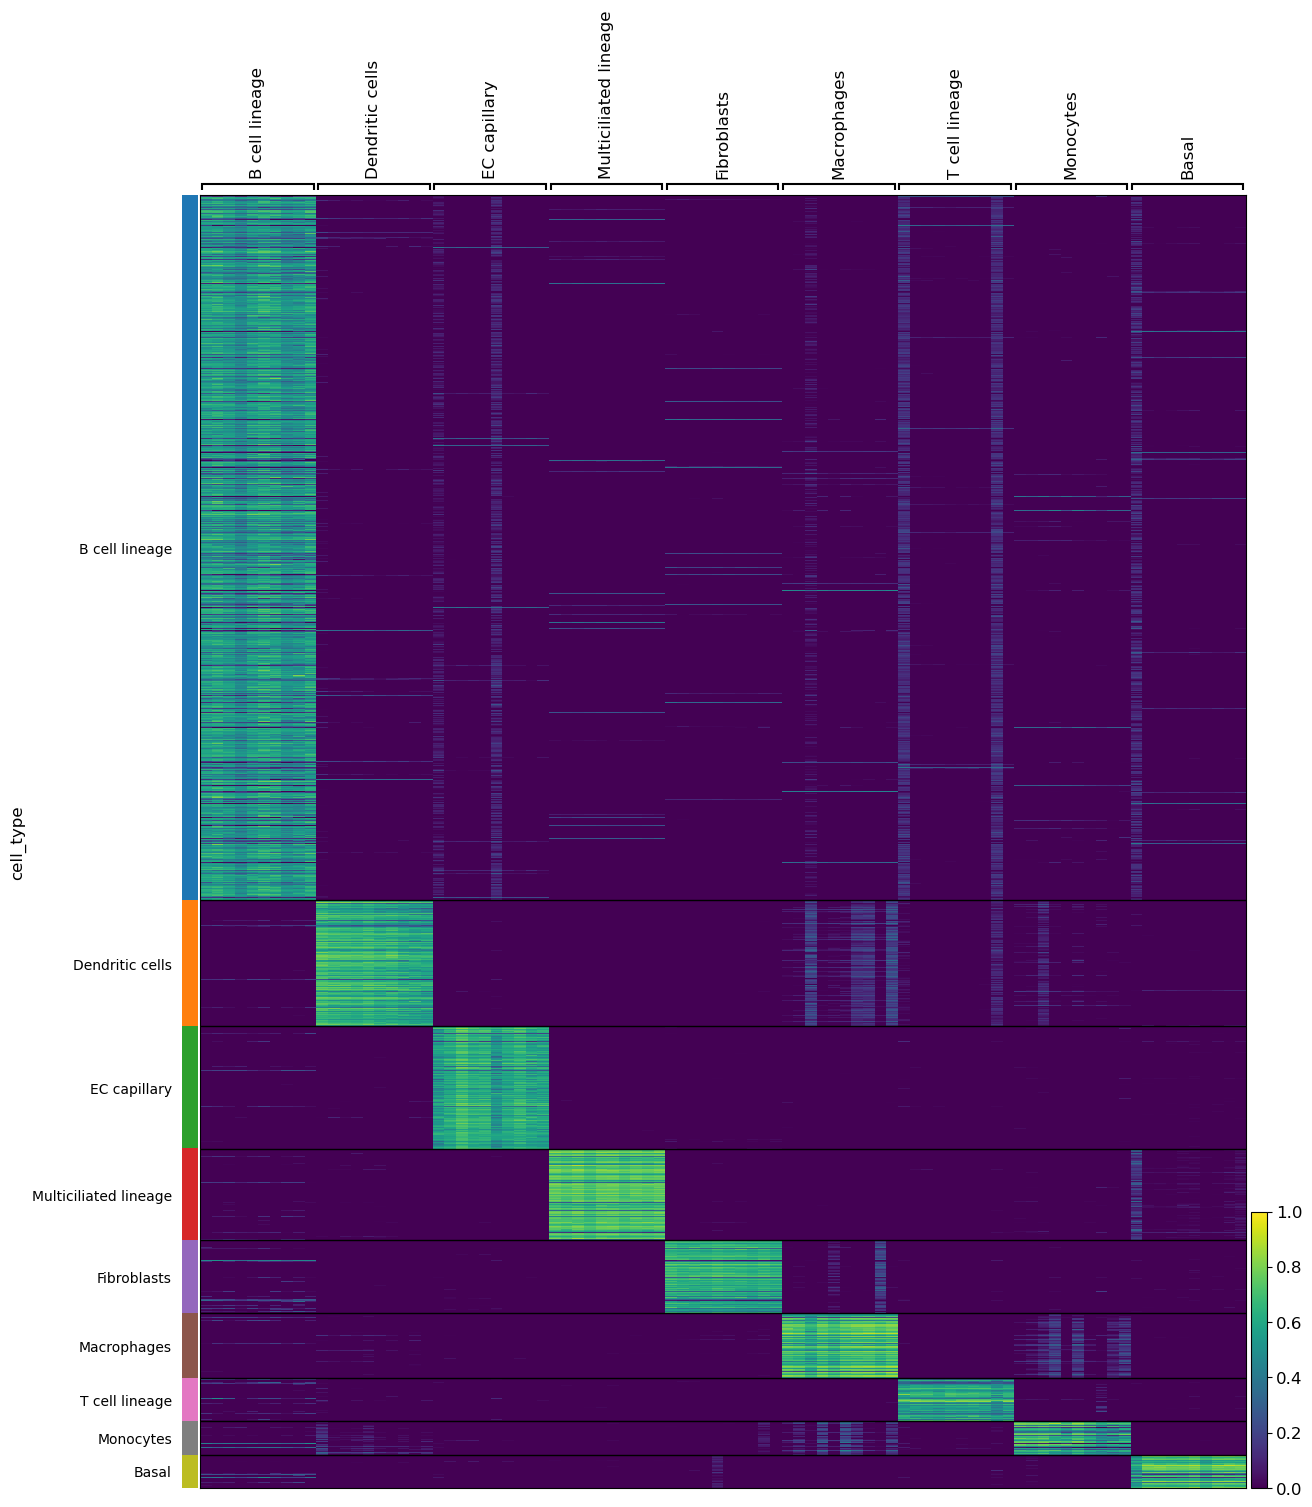

In [16]:
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 12
adata2.obs['cell_type'] = pd.Categorical(adata2.obs['cell_type'], categories=new_order, ordered=True)
print(adata2.obs['cell_type'].cat.categories)

cell_types = new_order

result = adata2.uns['rank_features_groups']

names_array = result['names']
scores_array = result['scores']
pvals_array = result['pvals']
pvals_adj_array = result['pvals_adj']
logfoldchanges_array = result['logfoldchanges']

# Reorder each array
def reorder_recarray(recarray, new_order):  
    new_dtype = [(name, recarray.dtype[name]) for name in new_order]
    new_recarray = np.empty(recarray.shape, dtype=new_dtype)
    for name in new_order:
        new_recarray[name] = recarray[name]
    return new_recarray

result['names'] = reorder_recarray(names_array, new_order)
result['scores'] = reorder_recarray(scores_array, new_order)
result['pvals'] = reorder_recarray(pvals_array, new_order)
result['pvals_adj'] = reorder_recarray(pvals_adj_array, new_order)
result['logfoldchanges'] = reorder_recarray(logfoldchanges_array, new_order)
adata2.uns['rank_features_groups']=result
groups =cell_types
markers = pd.DataFrame(
    {group +  key[:1]: result[key][group]
    for group in groups for key in ['names']}).head(10).T
markers = np.array(markers.values).reshape(1,-1)[0]
sc.pl.heatmap(adata2, markers, groupby='cell_type',var_group_positions = [(0,9),(10,19),(20,29),(30,39),(40,49),(50,59),(60,69),(70,79),(80,89),(90,99),(100,109),(110,119),(120,129),(130,139),(140,149),(150,159),(160,169),(170,179),(180,189),(190,199)],
              var_group_labels = cell_types,standard_scale="var",figsize=(14, 17),show = True)